In [2]:
%pip install datasets
from datasets import Dataset , DatasetDict
import os
import pandas as pd
import seaborn as sns
import gdown
from zipfile import ZipFile
from bs4 import BeautifulSoup
import re
import tensorflow as tf
from transformers import TFAutoModel , AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
# Download the dataset (resumes_corpus.zip) from Google Drive
file_id = '1auqXjex4Y_bih7TCQw-3D4j5MtHHt976'  # Updated with your actual file ID
url = f'https://drive.google.com/uc?id={file_id}'
output_zip = "resumes_corpus.zip"
gdown.download(url, output_zip, quiet=False)

# Unzip the archive to a directory
with ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("resumes_corpus")


Downloading...
From (original): https://drive.google.com/uc?id=1auqXjex4Y_bih7TCQw-3D4j5MtHHt976
From (redirected): https://drive.google.com/uc?id=1auqXjex4Y_bih7TCQw-3D4j5MtHHt976&confirm=t&uuid=33ad5d97-f3c3-4f96-8a08-d17d514820c6
To: /Users/kyledilao/Desktop/AY23:24 Sem 2/BT4222/BT4222_project-1/resumes_corpus.zip
100%|██████████| 94.4M/94.4M [01:13<00:00, 1.29MB/s]


In [43]:
# Define the directory where the unzipped files are stored
directory = "resumes_corpus/resumes_corpus/"
# Initialize lists to store the data
resumes = []
labels = []

# Loop through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        try:
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                soup = BeautifulSoup(content, 'html.parser')
                content = soup.get_text()
                # content = re.sub(r'[•-]', '.', content)
                resumes.append(content)
        except UnicodeDecodeError:
            with open(os.path.join(directory, filename), 'r', encoding='latin1') as file:
                content = file.read()
                soup = BeautifulSoup(content, 'html.parser')
                content = soup.get_text()
                resumes.append(content)
        base_filename = os.path.splitext(filename)[0]
        lab_filename = f'{base_filename}.lab'
        lab_file_path = os.path.join(directory,lab_filename)
        with open(lab_file_path , 'r') as file:
          label = file.read()
          labels.extend(label.split(','))

    elif filename.endswith(".lab"):
        continue
        # with open(os.path.join(directory, filename), 'r') as file:
        #     label = file.read()
        #     labels.extend(label.split(','))  # Split labels if there are multiple

# Create a DataFrame with the resumes and labels
df = pd.DataFrame({
    'resume': resumes,
    'labels': labels
})

df['labels'] = df['labels'].astype(str).str.split(r'\n')
df = df[df['labels'].apply(len) < 3 ]

In [61]:
# Explode the 'labels' column into separate rows
df_expanded = df.explode('labels')

# Remove any leading/trailing whitespace
df_expanded['labels'] = df_expanded['labels'].str.strip()

# Drop duplicates if any resume is linked to the same label more than once and null values created during the formation of dataframe
df_expanded = df_expanded.replace('', pd.NA)
df_expanded = df_expanded.dropna(how="any", subset= ['resume',"labels"], axis= 0)
df_expanded.drop_duplicates(subset=['resume', 'labels'], inplace=True)

# Reset index after explode to avoid any future issues with misaligned indexes
df_expanded.reset_index(drop=True, inplace=True)

# Explode the 'labels' column into separate rows if there are multiple labels

In [65]:
label_encoder =  LabelEncoder()
df_expanded['labels'] = df_expanded['labels'].apply(str)
df_expanded["Label_List"] = label_encoder.fit_transform(df_expanded['labels'])
label_mapping = dict(zip(label_encoder.classes_ , label_encoder.transform(label_encoder.classes_)))
df_expanded['labels']

0                Web_Developer
1           Software_Developer
2             Security_Analyst
3              Project_manager
4             Python_Developer
                 ...          
33274         Security_Analyst
33275    Network_Administrator
33276          Project_manager
33277            Web_Developer
33278       Software_Developer
Name: labels, Length: 33279, dtype: object

In [66]:
from sklearn.model_selection import train_test_split

train_df , test_df = train_test_split(df_expanded, test_size=0.3 , random_state= 42 )

train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
my_dataset_dict = DatasetDict({"train":train_dataset,"test":test_dataset})

In [67]:
my_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['resume', 'labels', 'Label_List'],
        num_rows: 23295
    })
    test: Dataset({
        features: ['resume', 'labels', 'Label_List'],
        num_rows: 9984
    })
})

In [68]:
def tokenize(batch):
    return tokenizer(batch['resume'], padding= True, truncation= True , return_tensors= 'pt')

In [69]:
df_encoded = my_dataset_dict.map(tokenize,batched=True)

Map: 100%|██████████| 9984/9984 [00:07<00:00, 1350.39 examples/s]


In [70]:
df_encoded

DatasetDict({
    train: Dataset({
        features: ['resume', 'labels', 'Label_List', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 23295
    })
    test: Dataset({
        features: ['resume', 'labels', 'Label_List', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9984
    })
})

In [71]:
df_encoded.set_format('tf',columns=['input_ids', 'attention_mask','token_type_ids','Label_List'])

In [72]:
# setting BATCH_SIZE to 16.
BATCH_SIZE = 16

In [73]:
def order(inp):
    '''
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.
    '''
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]


train_dataset = tf.data.Dataset.from_tensor_slices(df_encoded['train'][:])

train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)



test_dataset = tf.data.Dataset.from_tensor_slices(df_encoded['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# Exploratory Data Analysis

**Class Distribution**

Total number of resumes: 33279

There were multiple labels for some resumes. We chose to explode the labels to have a fairer distribution of resumes across each class. 
After exploding, we have an imbalanced distribution of classes:


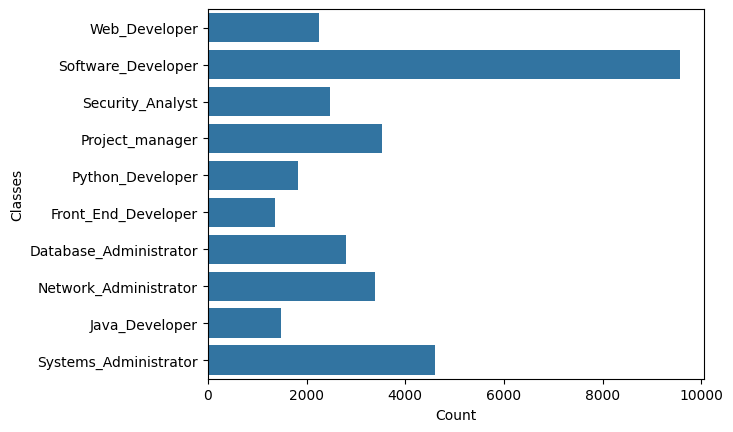

In [81]:
#Dataset Statistics
print(f"Total number of resumes: {len(df_expanded)}\n")

print("There were multiple labels for some resumes. We chose to explode the labels to have a fairer distribution of resumes across each class. \nAfter exploding, we have an imbalanced distribution of classes:")
# Create the countplot
ax = sns.countplot(df_expanded['labels'])

# Remove the axes description
ax.set_title('')

# Label the y and x axis
ax.set_ylabel('Classes')
ax.set_xlabel('Count')

plt.show()

## did we do anything to address toe class imbalance? ##

**Text Length Analysis**

The peak of the histogram is in the bin from 1502.14 to 2891.28


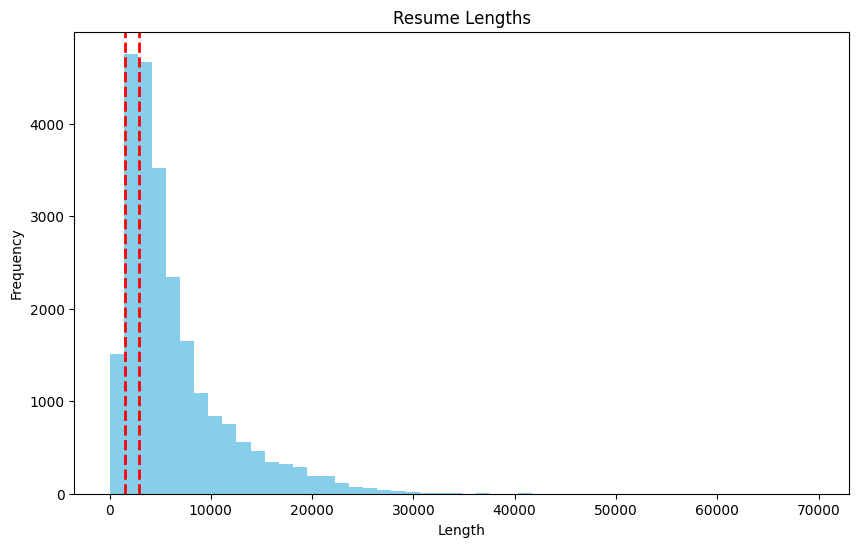

In [94]:
#explore resume lengths
import numpy as np

# Calculate histogram
df_expanded['resume_length'] = df_expanded['resume'].apply(len)
counts, bin_edges = np.histogram(df_expanded['resume_length'], bins=50)

# Find bin with highest count
max_count_index = np.argmax(counts)
peak_bin = (bin_edges[max_count_index], bin_edges[max_count_index + 1])

print(f"The peak of the histogram is in the bin from {peak_bin[0]} to {peak_bin[1]}")

# Plot a histogram of the resume lengths
plt.figure(figsize=(10, 6))
plt.hist(df['resume_length'], bins=50, color='skyblue')
plt.title('Resume Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.axvline(x=peak_bin[0], color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=peak_bin[1], color='r', linestyle='dashed', linewidth=2)
plt.show()

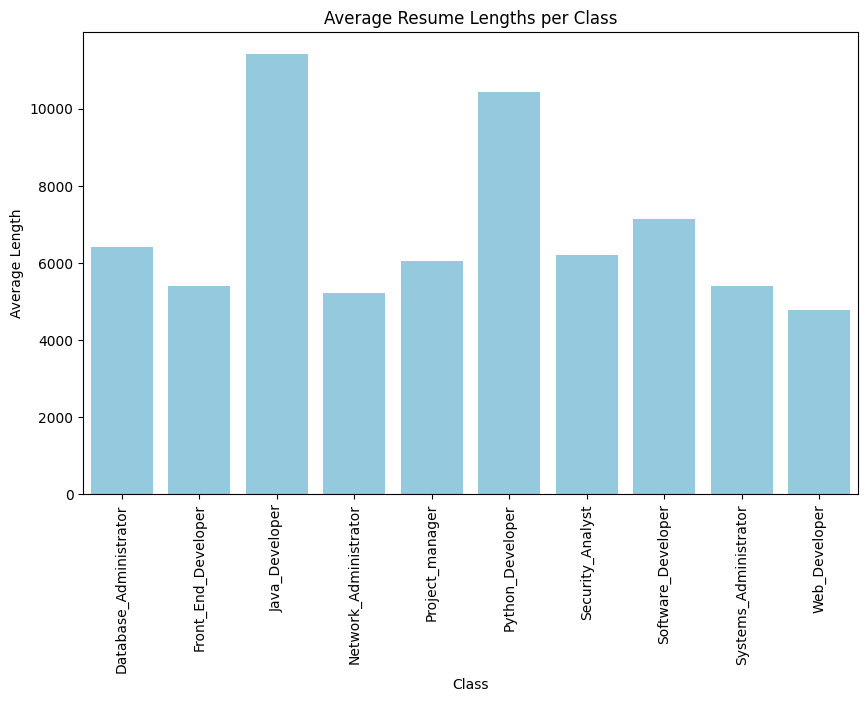

In [95]:
# Calculate the average resume length for each class
avg_lengths = df_expanded.groupby('labels')['resume_length'].mean()

# Create a bar plot of the average resume lengths
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_lengths.index, y=avg_lengths.values, color='skyblue')
plt.title('Average Resume Lengths per Class')
plt.xlabel('Class')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.ylabel('Average Length')
plt.show()

**Word Frequency Analysis**

In [107]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the data
data_corpus = vectorizer.fit_transform(df_expanded['resume'])

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Sum the counts of each word
word_counts = data_corpus.sum(axis=0).A1

# Create a Counter object with the word counts
word_counter = Counter(dict(zip(feature_names, word_counts)))

# Remove the word 'using'
if 'using' in word_counter:
    del word_counter['using']
    del word_counter['end']

# Print the 10 most common words
for word, count in word_counter.most_common(10):
    print(f"{word}: {count}")

data: 213487
web: 180454
experience: 146583
application: 136204
python: 128451
server: 128360
development: 127931
management: 127007
sql: 126301
database: 125898


In [109]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Group the DataFrame by the 'labels' column
for label, group in df_expanded.groupby('labels'):
    # Fit and transform the data
    data_corpus = vectorizer.fit_transform(group['resume'])

    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()

    # Sum the counts of each word
    word_counts = data_corpus.sum(axis=0).A1

    # Create a Counter object with the word counts
    word_counter = Counter(dict(zip(feature_names, word_counts)))

    # Remove the word 'using'
    if 'using' in word_counter:
        del word_counter['using']
        del word_counter['end']

    # Print the label and the 5 most common words
    print(f"Label: {label}")
    # Print the 10 most common words
    for word, count in word_counter.most_common(5):
        print(f"    {word}: {count}")

    print("\n")

Label: Database_Administrator
    database: 50292
    sql: 34442
    oracle: 28268
    data: 26782
    server: 21296


Label: Front_End_Developer
    web: 10879
    javascript: 8797
    developer: 8269
    js: 7823
    css: 6498


Label: Java_Developer
    java: 25331
    spring: 22064
    web: 20997
    application: 20828
    data: 20038


Label: Network_Administrator
    network: 38653
    support: 17343
    systems: 15547
    security: 15021
    cisco: 13888


Label: Project_manager
    project: 49437
    management: 28283
    manager: 21096
    business: 18263
    team: 13113


Label: Python_Developer
    python: 58471
    data: 35484
    web: 25283
    django: 22524
    developed: 20193


Label: Security_Analyst
    security: 45026
    information: 15005
    management: 13791
    systems: 11935
    network: 11850


Label: Software_Developer
    web: 88311
    data: 81583
    python: 63783
    application: 61054
    used: 57279


Label: Systems_Administrator
    systems: 34804
    

**N-gram Analysis**

***2-gram***

In [114]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 2))

# Group the DataFrame by the 'labels' column
for label, group in df_expanded.groupby('labels'):
    # Fit and transform the data
    data_corpus = vectorizer.fit_transform(group['resume'])

    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()

    # Sum the counts of each word
    word_counts = data_corpus.sum(axis=0).A1

    # Create a Counter object with the word counts
    word_counter = Counter(dict(zip(feature_names, word_counts)))

    # Remove the word 'using'
    if 'using' in word_counter:
        del word_counter['using']
        del word_counter['end']

    # Print the label and the 5 most common bigrams
    print(f"Label: {label}")
    for word, count in word_counter.most_common(5):
        print(f"    {word}: {count}")

    print("\n")

Label: Database_Administrator
    sql server: 14854
    database administrator: 9983
    oracle database: 5063
    performance tuning: 3816
    work experience: 2910


Label: Front_End_Developer
    end developer: 4415
    html css: 2157
    node js: 2041
    html5 css3: 1920
    angular js: 1817


Label: Java_Developer
    web services: 8093
    java developer: 5365
    java j2ee: 3364
    using spring: 3273
    spring boot: 3196


Label: Network_Administrator
    network administrator: 6171
    active directory: 5404
    work experience: 3450
    hardware software: 2801
    network engineer: 2587


Label: Project_manager
    project manager: 12929
    project management: 6707
    work experience: 3584
    10 years: 2682
    information technology: 1897


Label: Python_Developer
    using python: 13116
    python django: 10608
    python developer: 8660
    web services: 7149
    html css: 4001


Label: Security_Analyst
    information security: 5800
    security analyst: 5692
    cyb

***3-gram***

In [113]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))

# Group the DataFrame by the 'labels' column
for label, group in df_expanded.groupby('labels'):
    # Fit and transform the data
    data_corpus = vectorizer.fit_transform(group['resume'])

    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()

    # Sum the counts of each word
    word_counts = data_corpus.sum(axis=0).A1

    # Create a Counter object with the word counts
    word_counter = Counter(dict(zip(feature_names, word_counts)))

    # Remove the word 'using'
    if 'using' in word_counter:
        del word_counter['using']
        del word_counter['end']

    # Print the label and the 5 most common bigrams
    print(f"Label: {label}")
    for word, count in word_counter.most_common(5):
        print(f"    {word}: {count}")

    print("\n")

Label: Database_Administrator
    oracle database administrator: 2696
    ms sql server: 1720
    sql server database: 1326
    oracle enterprise manager: 1122
    sql server 2008: 1101


Label: Front_End_Developer
    developer end developer: 825
    html css javascript: 820
    end developer end: 790
    html5 css3 javascript: 680
    authorized work employer: 613


Label: Java_Developer
    restful web services: 1427
    web services using: 1178
    development life cycle: 1059
    software development life: 986
    environment java j2ee: 793


Label: Network_Administrator
    authorized work employer: 1348
    employer work experience: 1348
    work employer work: 1346
    work experience network: 1204
    administrator network administrator: 1133


Label: Project_manager
    authorized work employer: 1411
    employer work experience: 1409
    work employer work: 1409
    manager project manager: 1259
    senior project manager: 1204


Label: Python_Developer
    using python djan

**Word Cloud**

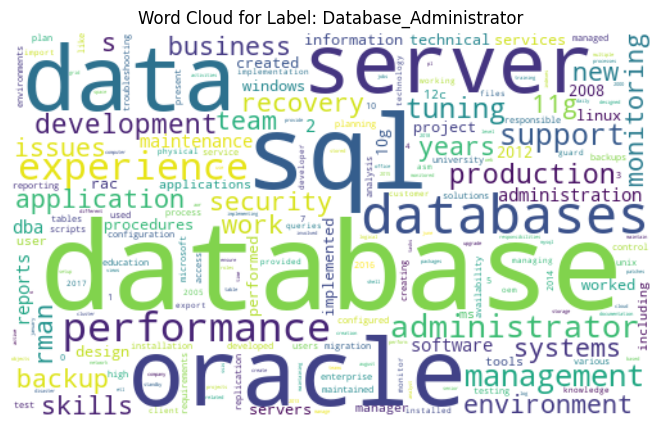

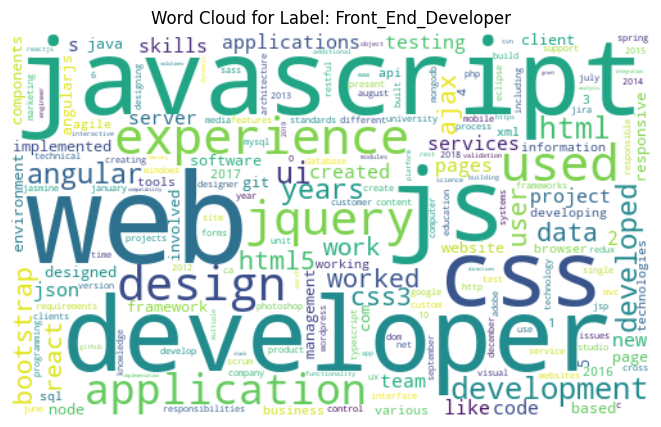

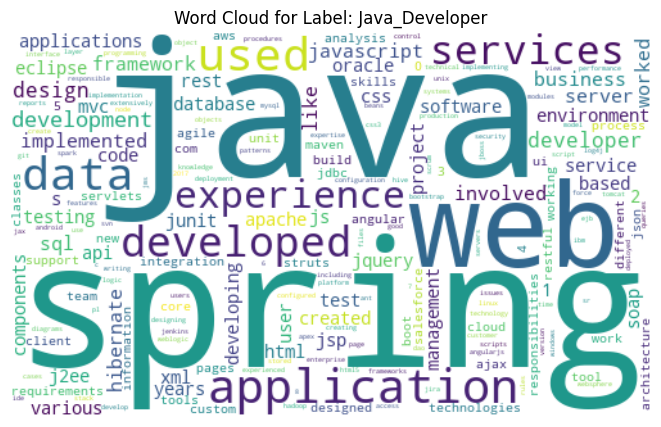

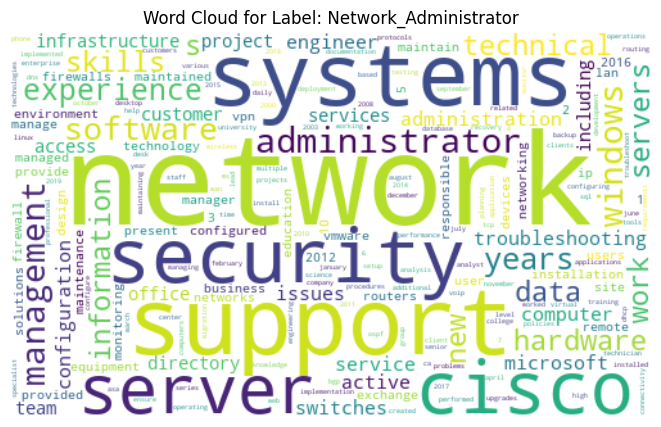

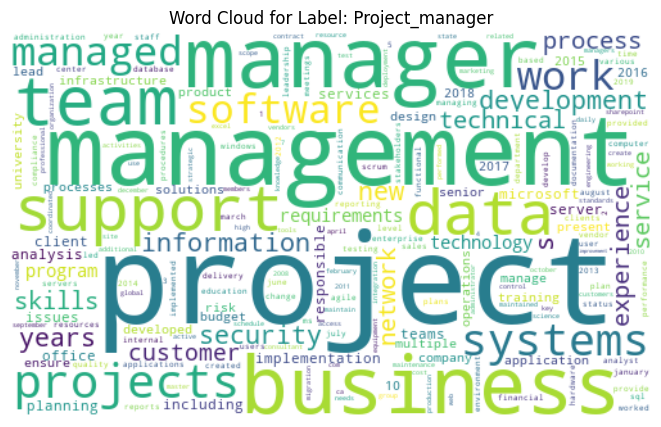

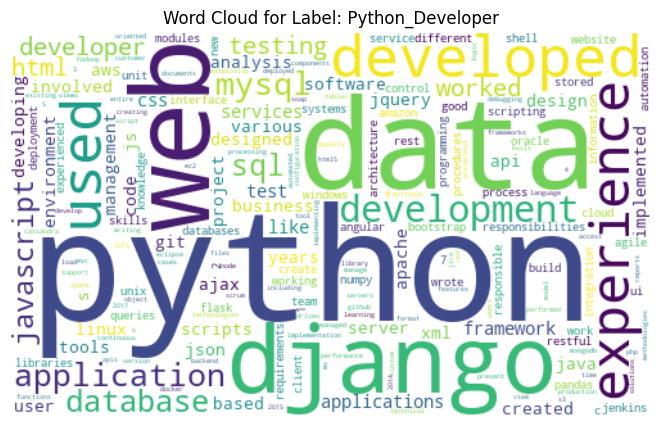

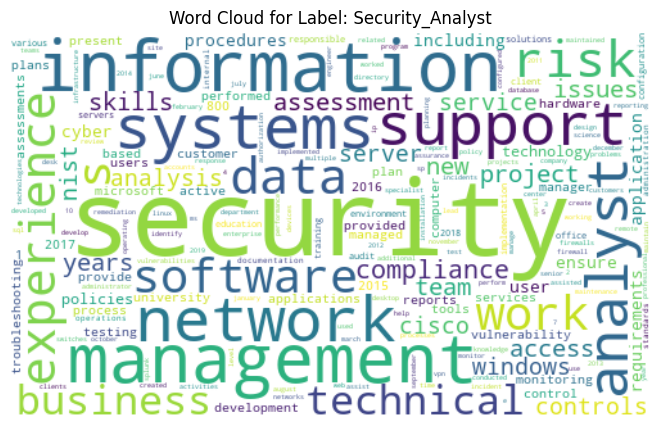

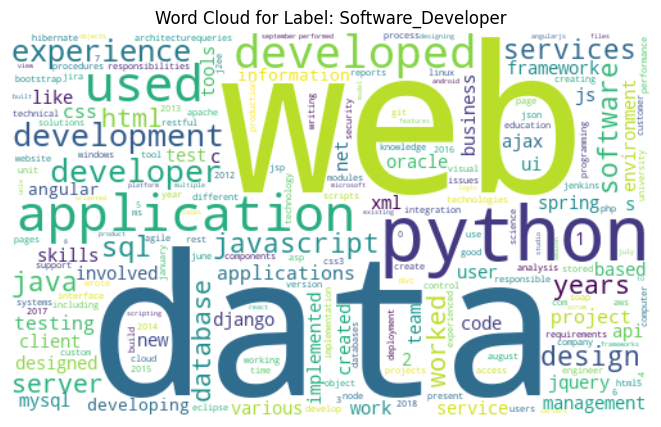

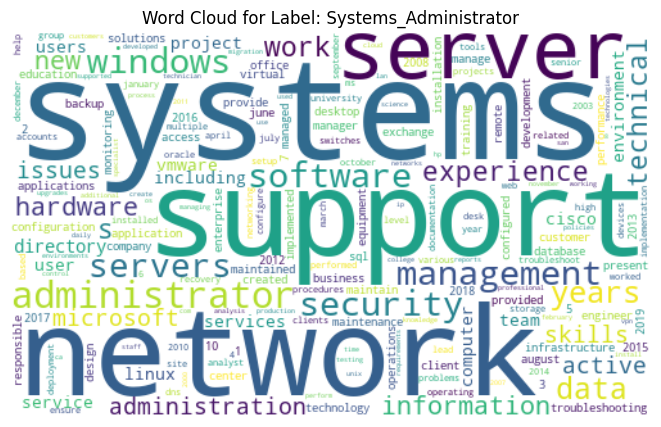

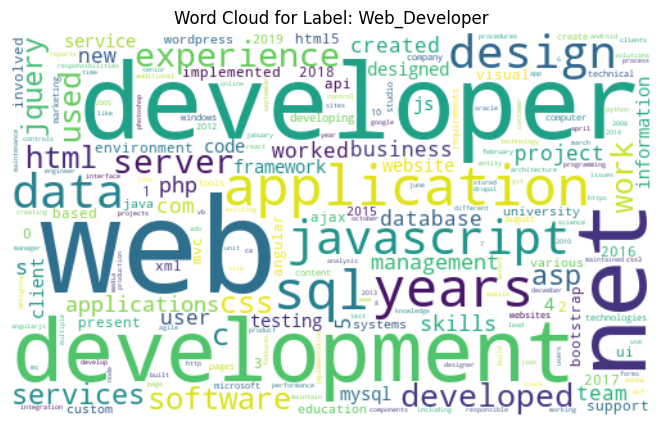

In [124]:
# %pip install wordcloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Preprocess the 'resume' data
df_expanded['resume'] = df_expanded['resume'].str.strip().str.replace(' +', ' ', regex=True)

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', lowercase=True, token_pattern='(?u)\\b\\w+\\b')

# Group the DataFrame by the 'labels' column
for label, group in df_expanded.groupby('labels'):
    # Fit and transform the data
    data_corpus = vectorizer.fit_transform(group['resume'])

    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()

    # Sum the counts of each word
    word_counts = data_corpus.sum(axis=0).A1

    # Create a Counter object with the word counts
    word_counter = Counter(dict(zip(feature_names, word_counts)))

    del word_counter['using']
    del word_counter['end']

    # Create a WordCloud object
    wordcloud = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(word_counter)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Label: {label}")
    plt.show()